# Trajectories

Here we will use Cicero again to estimate the trajectories of gene expression changes with scATAC-seq data.

https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/

In [1]:
library(cicero)
library(monocle3)
library(ggplot2)
library(patchwork)
library(stringr)
library(SeuratWrappers)
library(Signac)
library(Seurat)
set.seed(1234)

Loading required package: monocle3

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes conta

In [2]:
#Load data from previous notebook.
brain <- readRDS("./adult_mouse_brain/Outputs/brain_coaccs.rds")
DefaultAssay(brain) <- 'ATAC'
brain

An object of class Seurat 
184181 features across 3512 samples within 3 assays 
Active assay: ATAC (157203 features, 157203 variable features)
 2 other assays present: ACTIVITY, RNA
 2 dimensional reductions calculated: lsi, umap

In [3]:
input_cds <- as.cell_data_set(x=brain) 
#cluster cells
input_cds <- cluster_cells(input_cds)
#learn graph
input_cds <- learn_graph(input_cds)

Warning message:
"Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object"


  |======================================================================| 100%


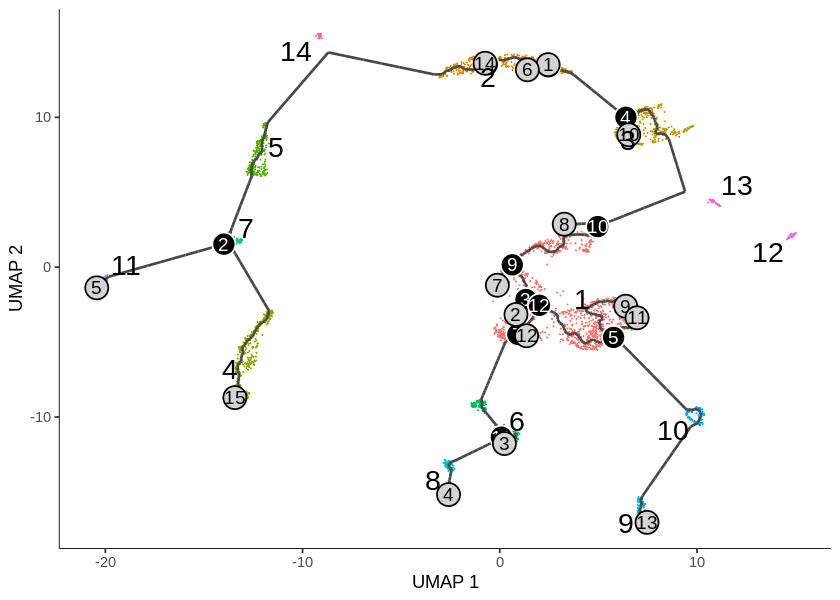

In [15]:
options(repr.plot.width=7, repr.plot.height=5)
plot_cells(input_cds, group_label_size=6, graph_label_size = 4)

In [28]:
# cell ordering
#if we are not in Rstudio, root_cells must be provided
#to get the names I ran the cell above differently : plot_cells(input_cds, label_principal_points = TRUE)
#but using monocle2, monocle3 does not provide the option anymore.
#Users of signac said they used the Rstudio version to get the names.
input_cds <- order_cells(input_cds, root_pr_nodes = c("Y_419", "Y_500"))

Cells aren't colored in a way that allows them to be grouped.



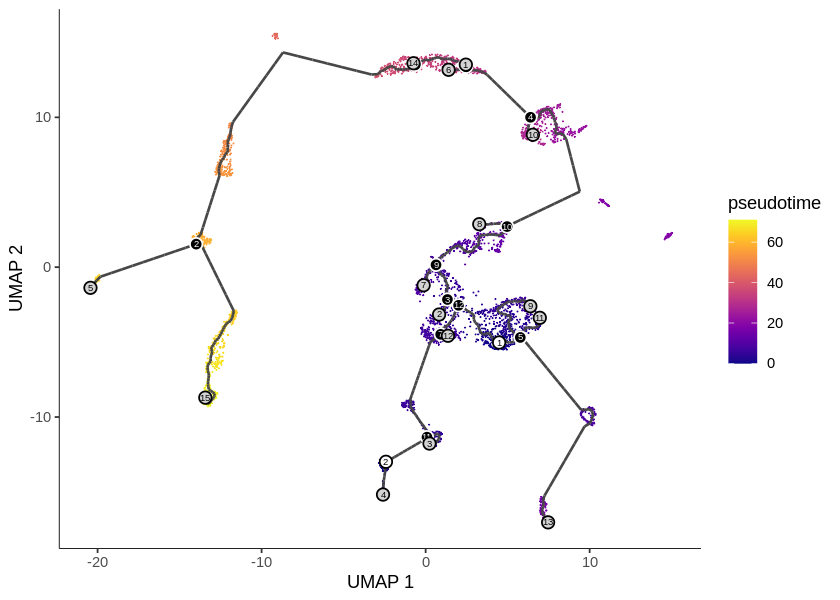

In [29]:
options(repr.plot.width=7, repr.plot.height=5)
plot_cells(input_cds, color_cells_by = "pseudotime")

## 8. Differential Accessibility Analysis

Once you have your cells ordered in pseudotime, you can ask where in the genome chromatin accessibility is changing across time. If you know of specific sites that are important to your system, you may want to visualize the accessibility at those sites across pseudotime.

*Aggregation: addressing sparsity for differential analysis*

*The primary way that the Cicero package deals with the sparsity of single-cell chromatin accessibility data is through aggregation. Aggregating the counts of either single cells or single peaks allows us to produce a "consensus" count matrix, reducing noise and allowing us to move out of the binary regime. Under this grouping, the number of cells in which a particular site is accessible can be modeled with a binomial distribution or, for sufficiently large groups, the corresponding Gaussian approximation. Modeling grouped accessibility counts as normally distributed allows Cicero to easily adjust them for arbitrary technical covariates by simply fitting a linear model and taking the residuals with respect to it as the adjusted accessibility score for each group of cells. We demonstrate how to apply this grouping practically below.*

In [30]:
input_cds_lin <- input_cds[,is.finite(pseudotime(input_cds))]

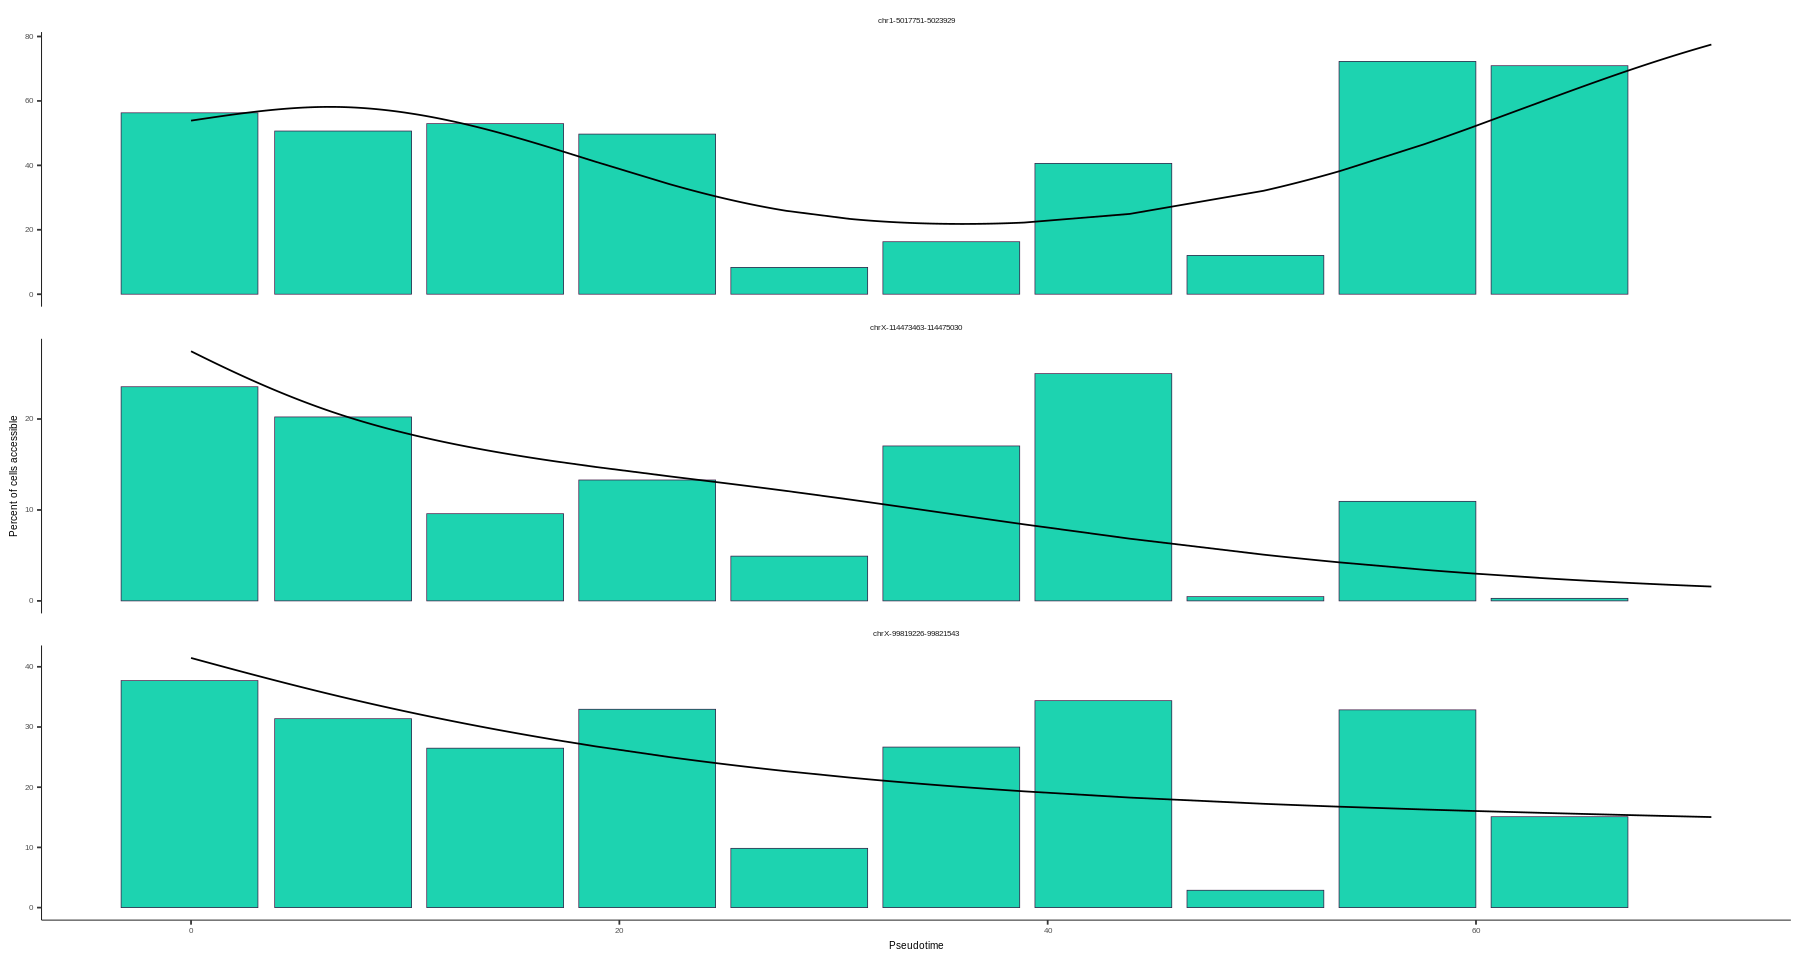

In [36]:
options(repr.plot.width=15, repr.plot.height=8)
plot_accessibility_in_pseudotime(input_cds_lin[c("chr1-5017751-5023929", 
                                                 "chrX-99819226-99821543", 
                                                 "chrX-114473463-114475030")])

we are interested in a site-level statistic (whether a site is changing in pseudotime), so we will aggregate similar cells.

In this example, we will assign cells to bins by cutting the pseudotime trajectory into 10 parts.

In [38]:
# First, assign a column in the pData table to umap pseudotime
pData(input_cds_lin)$Pseudotime <- pseudotime(input_cds_lin)
pData(input_cds_lin)$cell_subtype <- cut(pseudotime(input_cds_lin), 10)
binned_input_lin <- aggregate_by_cell_bin(input_cds_lin, "cell_subtype")

Now, we will find sites that are differentially accessible across pseudotime. 

In this example, we include num_genes_expressed as a covariate to substract its effect. 

https://cole-trapnell-lab.github.io/monocle3/docs/differential/#regression-analysis

In [39]:
# For speed, run fit_models on 1000 randomly chosen genes
set.seed(1000)
acc_fits <- fit_models(binned_input_lin[sample(1:nrow(fData(binned_input_lin)), 1000),], 
                       model_formula_str = "~Pseudotime + num_genes_expressed" )
fit_coefs <- coefficient_table(acc_fits)

# Subset out the differentially accessible sites with respect to Pseudotime
pseudotime_terms <- subset(fit_coefs, term == "Pseudotime" & q_value < .05)
head(pseudotime_terms)

site_name,num_cells_expressed,use_for_ordering,gene_id,model,model_summary,status,term,estimate,std_err,test_val,p_value,normalized_effect,model_component,q_value
<chr>,<int>,<lgl>,<chr>,<named list>,<named list>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
chr1-186702688-186706559,10,FALSE,chr1-186702688-186706559,"-0.1784395, 0.0342495, 3.101925e-05, NA, 4, 2.375247e-13, quasipoisson, log, function (mu) , log(mu), function (eta) , pmax(exp(eta), .Machine$double.eps), function (eta) , pmax(exp(eta), .Machine$double.eps), {, if (any(y < 0)) , stop(""negative values not allowed for the 'quasiPoisson' family""), n <- rep.int(1, nobs), mustart <- y + 0.1, }, function (eta) , TRUE, log, 7, 1442, 57730.25, 184097253, 57730.25, 3045188, 6848118502, 184097253, 6848118502, 2.417016e+13, 3.44289, 1, 2, 3, 3, 24.10023, eigen, NA, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, FALSE, 24.44483, 9, 548.4639, 10, 10, 1, TRUE, f_expression ~ Pseudotime + num_genes_expressed, speedglm::speedglm(formula = model_formula, family = stats::quasipoisson(), , model = FALSE, y = FALSE, acc = 0.001)","speedglm::speedglm(formula = model_formula, family = stats::quasipoisson(), , model = FALSE, y = FALSE, acc = 0.001), f_expression ~ Pseudotime + num_genes_expressed, quasipoisson, log, function (mu) , log(mu), function (eta) , pmax(exp(eta), .Machine$double.eps), function (mu) , mu, function (y, mu, wt) , {, r <- mu * wt, p <- which(y > 0), r[p] <- (wt * (y * log(y/mu) - (y - mu)))[p], 2 * r, }, function (y, n, mu, wt, dev) , NA, function (eta) , pmax(exp(eta), .Machine$double.eps), {, if (any(y < 0)) , stop(""negative values not allowed for the 'quasiPoisson' family""), n <- rep.int(1, nobs), mustart <- y + 0.1, }, function (mu) , all(is.finite(mu)) && all(mu > 0), function (eta) , TRUE, 24.44483, NA, 7, 548.4639, 9, 4, 2.375247e-13, 10, TRUE, 10, NA, 24.10023, 3, -0.1784395, 0.0342495, 3.101925e-05, 0.5423769, 0.003254528, 3.414426e-06, -0.3289955, 10.52365, 9.084763, 0.7517833, 1.526683e-05, 4.013226e-05, 3.44289, FALSE, 0.08544354, -0.0004307367, -5.287588e-07, -0.0004307367, 3.076471e-06, 2.409144e-09, -5.287588e-07, 2.409144e-09, 3.386198e-12, 0.2941727, -0.001482979, -1.820458e-06, -0.001482979, 1.059195e-05, 8.294418e-09, -1.820458e-06, 8.294418e-09, 1.165831e-11",OK,Pseudotime,0.0342495,0.003254528,10.523646,1.526683e-05,4.883769e-02,count,0.0151446931
chr5-131171532-131171837,4,FALSE,chr5-131171532-131171837,"-90.51182, 0.2975483, 0.0005838709, NA, 9, 8.19792e-13, quasipoisson, log, function (mu) , log(mu), function (eta) , pmax(exp(eta), .Machine$double.eps), function (eta) , pmax(exp(eta), .Machine$double.eps), {, if (any(y < 0)) , stop(""negative values not allowed for the 'quasiPoisson' family""), n <- rep.int(1, nobs), mustart <- y + 0.1, }, function (eta) , TRUE, log, 7, 39, 645.4, 5882886, 645.4, 14324.21, 95586454, 5882886, 95586454, 888295406417, 0.1342346, 1, 2, 3, 3, 0.939642, eigen, NA, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, FALSE, 1.169767, 9, 88.8596, 10, 10, 1, TRUE, f_expression ~ Pseudotime + num_genes_expressed, speedglm::speedglm(formula = model_formula, family = stats::quasipoisson(), , model = FALSE, y = FALSE, acc = 0.001)","speedglm::speedglm(formula = model_formula, family = stats::quasipoisson(), , model = FALSE, y = FALSE, acc = 0.001), f_expression ~ Pseudotime + num_genes_expressed, quasipoisson, log, function (mu) , log(mu), function (eta) , pmax(exp(eta), .Machine$double.eps), function (mu) , mu, function (y, mu, wt) , {, r <- mu * wt, p <- which(y > 0), r[p] <- (wt * (y * log(y/mu) - (y - mu)))[p], 2 * r, }, function (y, n, mu, wt, dev) , NA, function (eta) , pmax(exp(eta), .Machine$double.eps), {, if (any(y < 0)) , stop(""negative values not allowed for the 'quasiPoisson' family""), n <- rep.int(1, nobs), mustart <- y + 0.1, }, function (mu) , all(is.finite(mu)) && all(mu > 0), function (eta) , TRUE, 1.169767, NA, 7, 88.8596, 9, 9, 8.19792e-13, 10, TRUE, 10, NA, 0.939642, 3, -90.51182, 0.2975483, 0.0005838709, 8.755306, 0.027414